In [1]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.transformation import FromBuffer , CutPSD
import matplotlib.pyplot as plt
from torch import nn 

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
events = settings.state.to_dict()

In [3]:
from hannover_pylon.data import datamodules_pivot as dmp
from hannover_pylon.modelling.transformation import NormLayer 
import numpy as np
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
query_key = f'''
    SELECT DISTINCT date
    FROM data
    WHERE sensor = "accel" AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
    ORDER BY date
'''
columns = ['psd', 'level', 'direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(max_val = 4.96, min_val = -5.46, denormalize=False)), 
                  nn.Identity(),nn.Identity()]

# Initialize DataModule
data_module = dmp.PSDDataModule(
    db_path=db_path,
    query_key=query_key,
    columns=columns,
    transform_func=transform_func,
    batch_size=64,
    num_workers=16,
    return_dict=True
)


# Normal dense Autoencoder for all sensors feed together

In [4]:
import torch
class PrintShape(torch.nn.Module):
    def forward(self, x):
        return x
class DenseAutoencoder(nn.Module):
    def __init__(self, num_sensors: int, input_size: int, latent_dim: int):
        super(DenseAutoencoder, self).__init__()
        self.num_sensors = num_sensors
        self.input_size = input_size
        self.input_dim = num_sensors * input_size
        
        # Encoder
        self.encoder = nn.Sequential(
            PrintShape(),
            nn.Flatten(),  # Flatten the input
            PrintShape(),
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Latent space
        )
        
        # Decode
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, self.num_sensors, self.input_size)  # Reshape back to [B, num_sensors, time_steps]
        return x
    
import pytorch_lightning as pl
class ReconstructionLoss(pl.LightningModule):
    def __init__(self,num_sensors: int, input_size: int, latent_dim: int):
        super(ReconstructionLoss, self).__init__()
        self.input_size = input_size
        self.latent_size = latent_dim
        self.model = DenseAutoencoder(num_sensors= num_sensors, input_size=input_size, latent_dim=latent_dim)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])
        x_hat = self(x)
        loss = self.loss(x_hat, x)

        self.log('train_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])
        x_hat = self(x)
        loss = self.loss(x_hat, x)
        self.log('val_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [5]:
# train the model
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import MLFlowLogger
mlflow = MLFlowLogger(experiment_name='Multi_AE',
                      log_model=True,
                      save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')

model = ReconstructionLoss(num_sensors=18, input_size=1490, latent_dim=8)
trainer = pl.Trainer(max_epochs=100, logger=mlflow, callbacks=[checkpoint_callback])
trainer.fit(model, data_module)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseAutoencoder | 6.9 M  | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.642    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 99: 100%|██████████| 110/110 [00:04<00:00, 26.04it/s, v_num=f6b2, train_loss_step=0.000136, val_loss=0.000156, train_loss_epoch=0.000156]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 110/110 [00:04<00:00, 26.03it/s, v_num=f6b2, train_loss_step=0.000136, val_loss=0.000156, train_loss_epoch=0.000156]


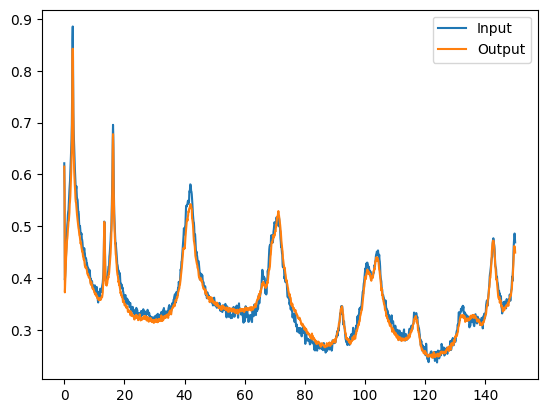

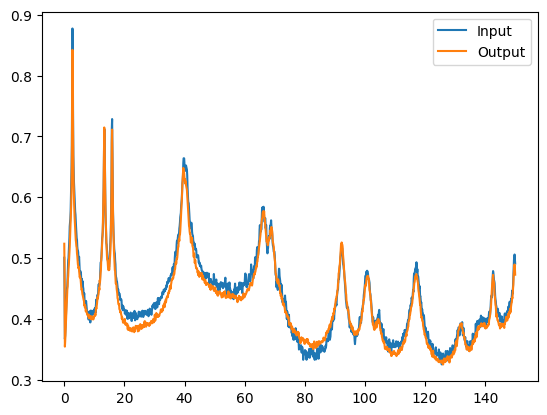

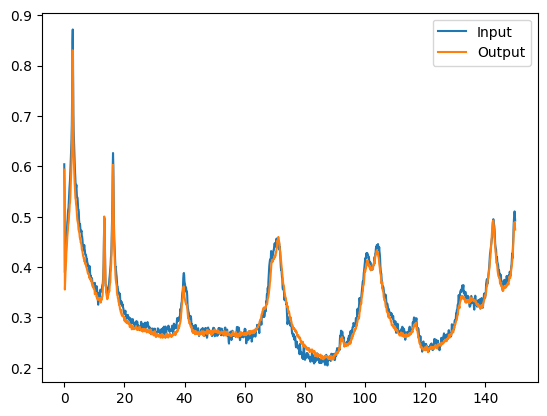

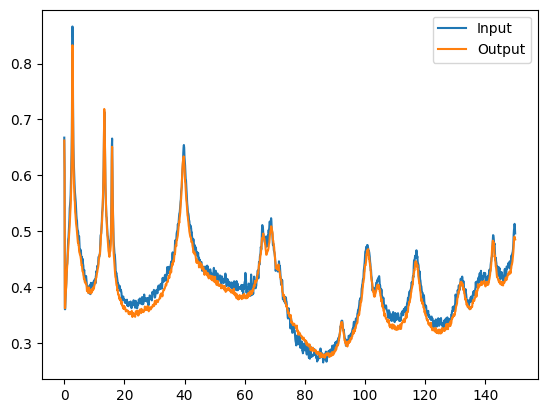

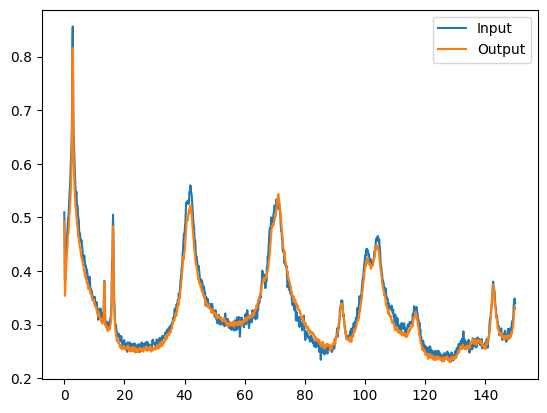

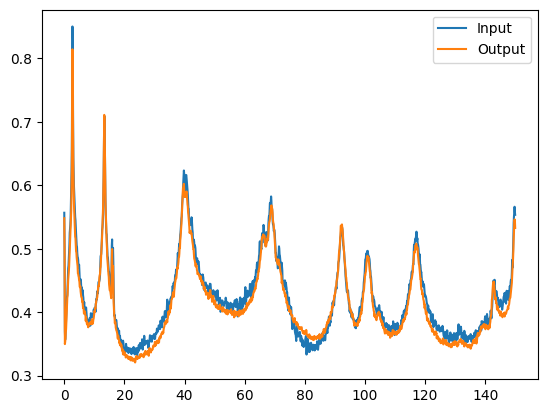

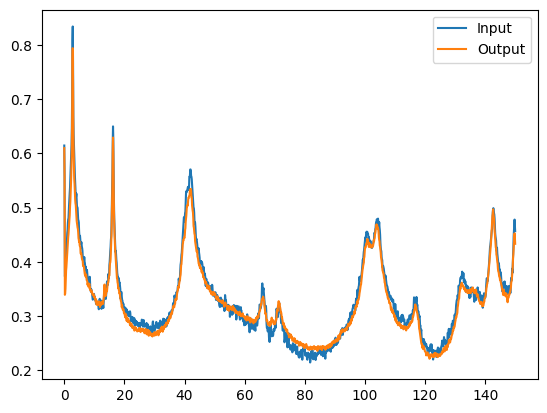

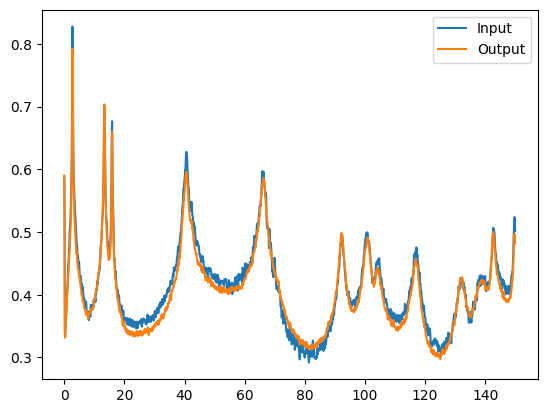

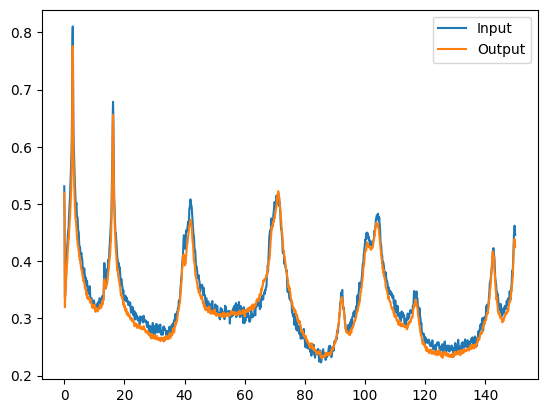

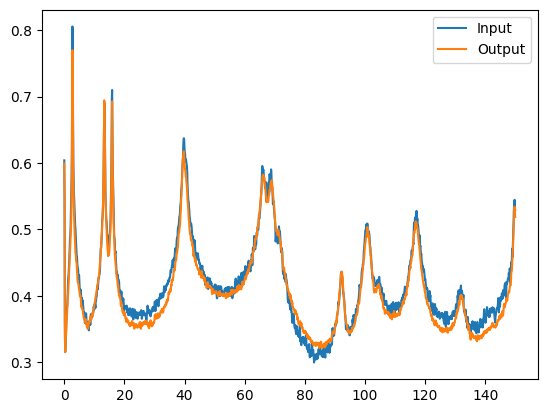

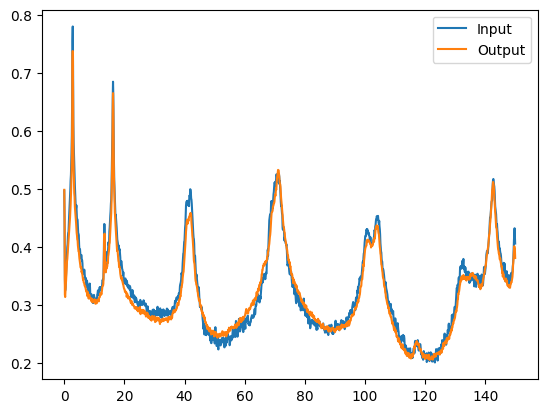

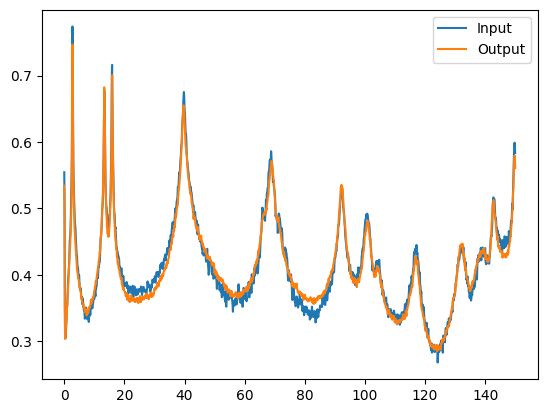

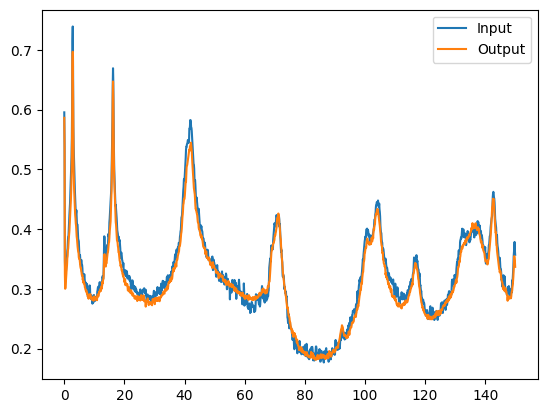

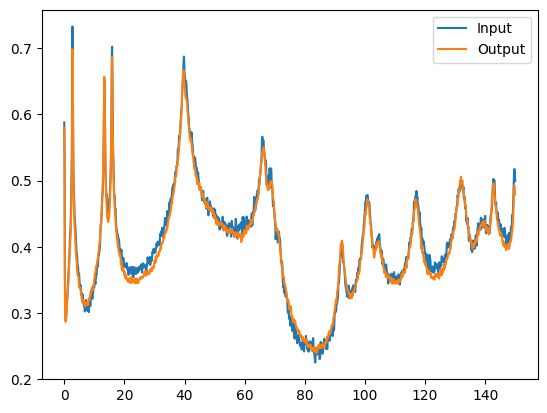

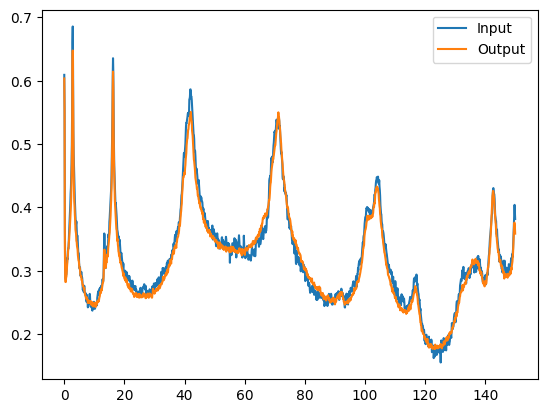

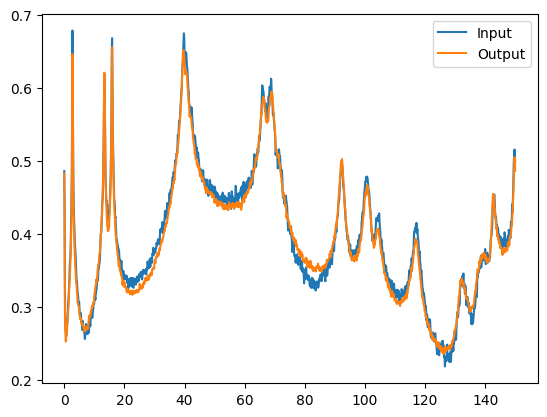

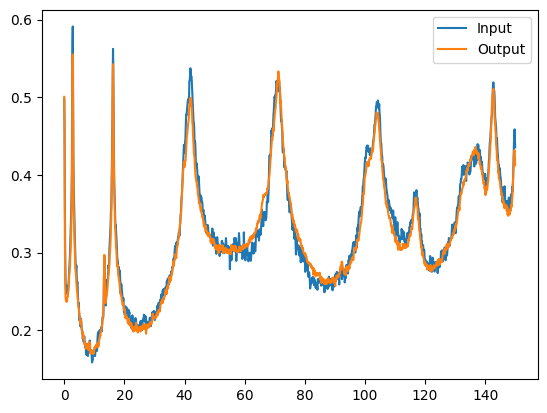

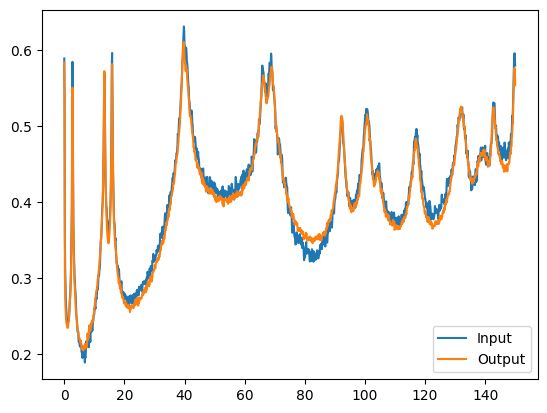

In [6]:
model.eval()
# Get a batch of data

batch = next(iter(data_module.val_dataloader()))
psd_in = torch.stack(batch['psd'])
psd_out = model.model(psd_in)
psd_in = psd_in[5]
psd_out = psd_out[5]

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [7]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        
    def mse(self, x):

        with torch.no_grad():
            x_hat = self.model.model(x)
        err = x - x_hat
        err = torch.mean(err**2, dim=(1,2))
        # compute the correlation between each sensor and all the other errors 
        corr = torch.corrcoef(err)
        return corr

    def forward(self, x):
        x = x.to(self.device)
        return self.mse(x)




In [8]:
from hannover_pylon.data import datamodules_pivot as dmp
from hannover_pylon.modelling.transformation import NormLayer 
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
query_key = f'''
    SELECT DISTINCT date
    FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
    ORDER BY date
'''
columns = ['psd','date', 'level', 'direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(max_val = 4.96, min_val = -5.46, denormalize=False)), 
                  nn.Identity(),nn.Identity(),nn.Identity()]

# Initialize DataModule
data_module_test = dmp.PSDDataModule(
    db_path=db_path,
    query_key=query_key,
    columns=columns,
    transform_func=transform_func,
    batch_size=1000,
    num_workers=1,
    return_dict=True
)
data_module_test.setup()


In [121]:
import torch
import torch.nn as nn

class DetectorLocalizer(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        
    def compute_correlation_matrices(self, x):
        with torch.no_grad():
            x_hat = self.model.model(x)
        err = x - x_hat  # Reconstruction errors, shape: [batch_size, num_sensors, input_size]
        psds = x  # Input PSDs, shape: [batch_size, num_sensors, input_size]

        batch_size, num_sensors, input_size = psds.shape

        # Center the data over the input dimension (e.g., frequency bins)
        psds_centered = psds - psds.mean(dim=2, keepdim=True)
        err_centered = err - err.mean(dim=2, keepdim=True)

        # Compute standard deviations over the input dimension
        psds_std = psds_centered.std(dim=2, unbiased=False, keepdim=True)
        err_std = err_centered.std(dim=2, unbiased=False, keepdim=True)

        # Expand dimensions for broadcasting
        psds_expanded = psds_centered.unsqueeze(2)  # Shape: [batch_size, num_sensors, 1, input_size]
        err_expanded = err_centered.unsqueeze(1)    # Shape: [batch_size, 1, num_sensors, input_size]

        # Compute covariance between each sensor's PSD and each sensor's error
        cov = np.abs((psds_expanded * err_expanded).mean(dim=3))  # Shape: [batch_size, num_sensors, num_sensors]

        # Compute correlation coefficients
        psds_std_expanded = psds_std  # Shape: [batch_size, num_sensors, 1]
        err_std_expanded = err_std.transpose(1, 2)  # Shape: [batch_size, 1, num_sensors]

        denominator = psds_std_expanded * err_std_expanded  # Shape: [batch_size, num_sensors, num_sensors]
        corr = cov / denominator

        # Handle any potential division by zero or NaNs
        corr = torch.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        # mean over the last dimension
        corr = corr.mean(dim=-1)
        return corr  # Shape: [batch_size, num_sensors, num_sensors]

    def compute_cosine_distance_matrices(self, x):
        with torch.no_grad():
            x_hat = self.model.model(x)
        err = x - x_hat  # Reconstruction errors, shape: [batch_size, num_sensors, input_size]
        psds = x         # Input PSDs, shape: [batch_size, num_sensors, input_size]

        batch_size, num_sensors, input_size = psds.shape

        # Normalize the data over the input dimension (e.g., frequency bins)
        psds_norm = psds / psds.norm(dim=2, keepdim=True)  # Shape: [batch_size, num_sensors, input_size]
        err_norm = err / err.norm(dim=2, keepdim=True)     # Shape: [batch_size, num_sensors, input_size]

        # Expand dimensions for broadcasting
        psds_expanded = psds_norm.unsqueeze(2)  # Shape: [batch_size, num_sensors, 1, input_size]
        err_expanded = err_norm.unsqueeze(1)    # Shape: [batch_size, 1, num_sensors, input_size]

        # Compute cosine similarity between each sensor's PSD and each sensor's error
        cos_sim = torch.sum(psds_expanded * err_expanded, dim=-1)  # Shape: [batch_size, num_sensors, num_sensors]

        # Compute cosine distance
        cos_dist =  cos_sim  # Shape: [batch_size, num_sensors, num_sensors]

        # Handle any potential division by zero or NaNs
        cos_dist = torch.nan_to_num(cos_dist, nan=0.0, posinf=0.0, neginf=0.0)
        cos_dist = cos_dist.mean(dim=-1)
        return cos_dist  # Shape: [batch_size, num_sensors, num_sensors]
            
    def forward(self, x):
        x = x.to(self.device)
        corr_matrices = self.compute_cosine_distance_matrices(x)
        return corr_matrices


In [122]:
import pandas as pd 
detector = Detector(model)
detector_localizer = DetectorLocalizer(model)

df_res = []

for batch in data_module_test.all_dataloader():
    psds = torch.stack(batch['psd'])
    dates = np.stack(batch['date']).flatten()
    directions = np.stack(batch['direction']).flatten()
    levels = np.stack(batch['level']).flatten()
    ai = detector_localizer(psds).flatten()
 
    df_temp = pd.DataFrame({'date': dates, 'ai': ai, 'direction': directions, 'level': levels})
    df_res.append(df_temp)


In [119]:
df_res = pd.concat(df_res)

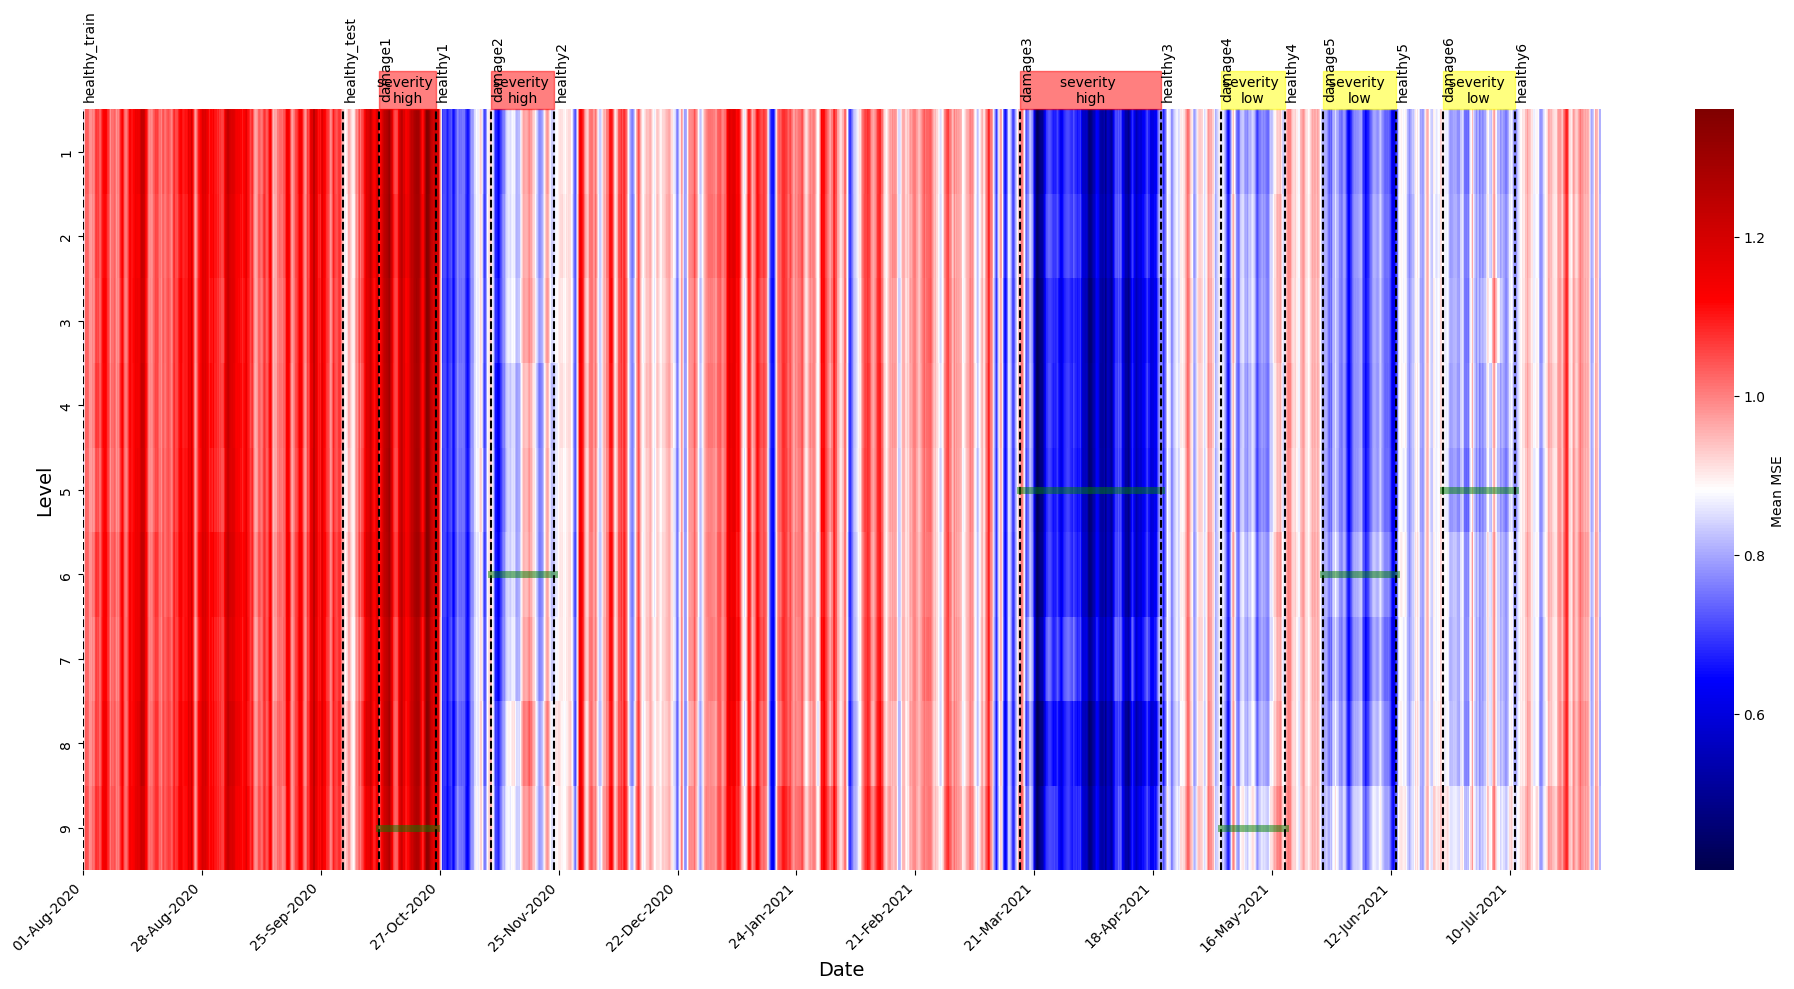

In [120]:
from matplotlib.ticker import FuncFormatter

def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        if 0 <= int(x) < len(column_dates):
            return column_dates[int(x)].strftime('%d-%b-%Y')
        return ''  # Return empty string if out of range
    return FuncFormatter(custom_date_format)

# Apply the custom date formatter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from functools import partial

# Filter the dataframe for 'y' direction and pivot the data for the heatmap
df_res['date'] = pd.to_datetime(df_res['date'])
df_res_y = df_res[df_res['direction'] == 'y']
df_pivot = df_res_y.pivot_table(index='level', columns=['date'], values='ai', aggfunc='mean')
# average the mse over 1hours rolling window with 1 hour step
df_pivot = df_pivot.T.rolling('1D', min_periods=1).mean().T# Create the heatmap plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the heatmap with seaborn
df_pivot.columns = pd.to_datetime(df_pivot.columns)

sns.heatmap(
    df_pivot, 
    cmap='seismic',  # Set the color map to 'seismic' for highlighting extremes
    cbar_kws={'label': 'Mean MSE'},  # Add a color bar label
    ax=ax,
)
# Set axis labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)
ax.xaxis.set_major_formatter(create_date_formatter(df_pivot.columns))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    idx_start = np.cumsum(df_pivot.columns < start)[-1]
    idx_end = np.cumsum(df_pivot.columns < end)[-1]
    
    # Draw vertical line and label for event
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line for the closest sensor level during the event
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start / len(df_pivot.columns), xmax=idx_end / len(df_pivot.columns), 
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a box above the plot to indicate severity
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        # Add rectangle patch above the plot to indicate severity
        box_height = 0.05  # Height of the box
        ax.add_patch(Rectangle(
            (idx_start, 1),  # Starting point of the box (above the plot)
            width=idx_end - idx_start,                # Width of the box
            height=box_height,                        # Height of the box
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),       # Transform to place above the x-axis
            clip_on=False                             # Make sure the rectangle is not clipped
        ))
        ax.text((idx_start + idx_end) / 2, -0.1+ box_height, 'severity \n'+severity, ha='center', va='bottom', color='black')
# Tighten the layout
plt.tight_layout()
plt.savefig('ControlChart_AE_PSD_version_1.png')

# Show the plot
plt.show()


In [67]:
def add_events(ax,x_axis,events):
    for event in events:
        start = pd.to_datetime(events[event]['start'])
        end = pd.to_datetime(events[event]['end'])
        idx_start = np.cumsum(x_axis < start)[-1]
        
        ax.axvline(idx_start, color='black', linestyle='--', label=f'{event} start')
        ax.text(idx_start, -0.1, f'{event}', rotation=90, va='bottom', ha='left')

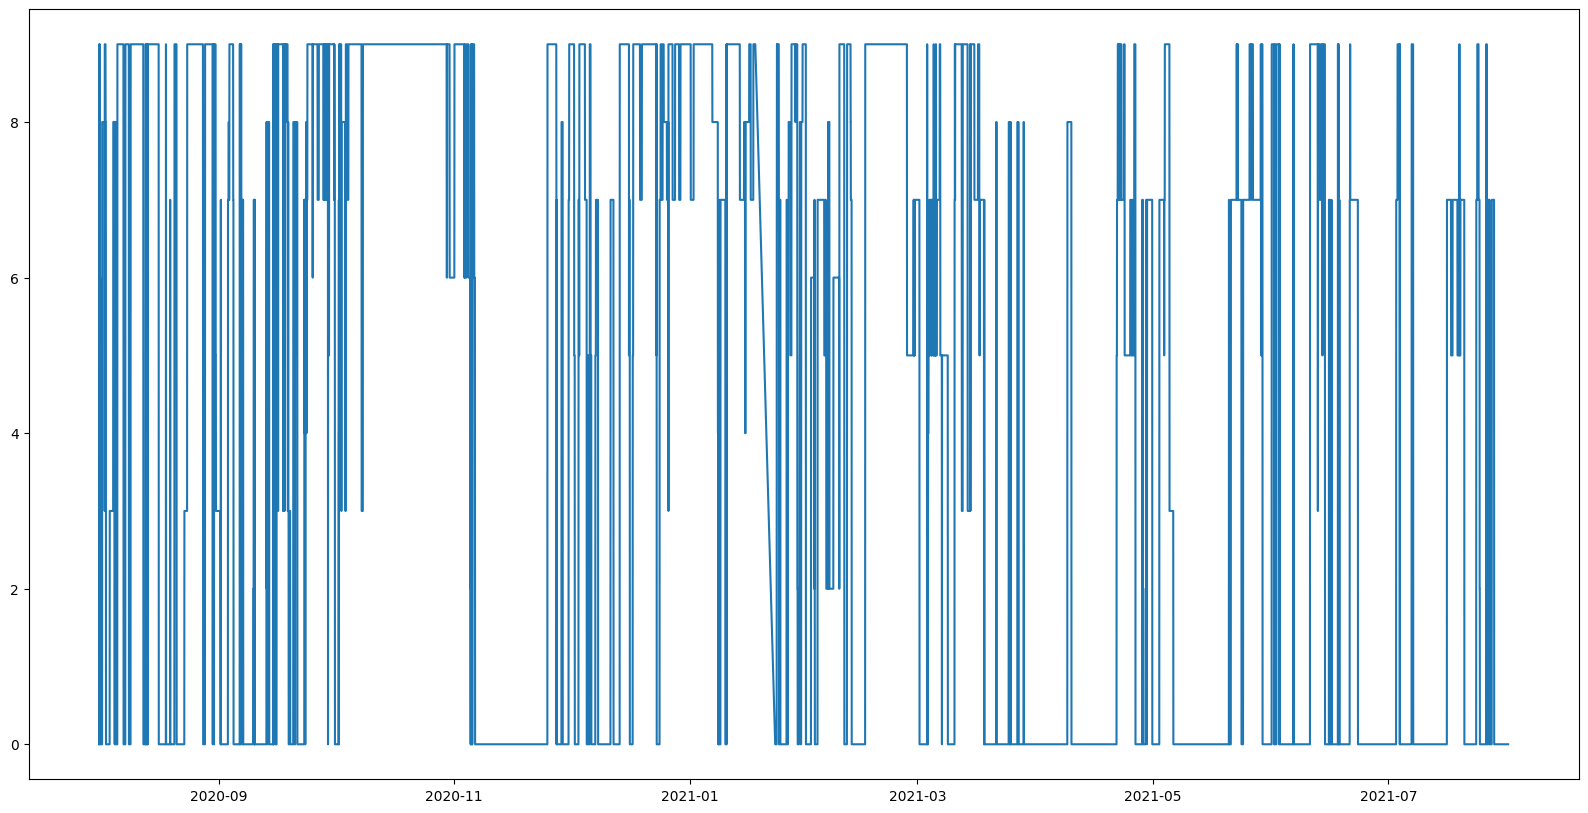

In [96]:
# compute the derivative of the mse over the level 
df_pivot_diff = df_pivot.diff(axis=0)
df_pivot_all = np.sum(df_pivot_diff, axis=0)

# take the maximum argument over the levels 
df_pivot_diff = df_pivot_diff.idxmax(axis=0) 
# if anomaly score is lower than 0.1, set it to 0
df_pivot_diff[df_pivot_all < 0.02] = 0
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df_pivot_diff.index, df_pivot_diff)


# single encoder interacte in latent space and single decoder

In [ ]:
import torch
from torch import nn
import pytorch_lightning as pl

class DenseAutoencoder(nn.Module):
    def __init__(self, num_sensors: int, input_size: int, latent_dim: int):
        super(DenseAutoencoder, self).__init__()
        self.num_sensors = num_sensors
        self.input_size = input_size
        self.latent_dim = latent_dim

        # Independent processing for each sensor
        self.sensor_encoder = nn.Sequential(
            nn.Linear(input_size, 64),  # Independent per sensor
            nn.ReLU(),
            nn.Linear(64, 32),  # Independent per sensor
            nn.ReLU()
        )

        # Shared latent interaction
        self.latent_encoder = nn.Sequential(
            nn.Linear(num_sensors * 32, latent_dim),  # Sensors interact here
            nn.ReLU()
        )

        # Shared latent interaction decoder
        self.latent_decoder = nn.Sequential(
            nn.Linear(latent_dim, num_sensors * 32),  # Sensors interact here
            nn.ReLU()
        )

        # Independent reconstruction for each sensor
        self.sensor_decoder = nn.Sequential(
            nn.Linear(32, 64),  # Independent per sensor
            nn.ReLU(),
            nn.Linear(64, input_size)  # Independent per sensor
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Process each sensor independently in the encoder
        x = x.view(batch_size * self.num_sensors, self.input_size)  # Flatten sensors into batch dimension
        x = self.sensor_encoder(x)
        x = x.view(batch_size, self.num_sensors * 32)  # Combine all sensors into a single vector

        # Shared latent space
        x = self.latent_encoder(x)

        # Decode from latent space
        x = self.latent_decoder(x)
        x = x.view(batch_size * self.num_sensors, 32)  # Split back into individual sensors
        x = self.sensor_decoder(x)
        x = x.view(batch_size, self.num_sensors, self.input_size)  # Reshape to original [B, num_sensors, input_size]

        return x


class ReconstructionLoss(pl.LightningModule):
    def __init__(self, num_sensors: int, input_size: int, latent_dim: int):
        super(ReconstructionLoss, self).__init__()
        self.model = DenseAutoencoder(num_sensors, input_size, latent_dim)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # Assuming batch['psd'] shape: [B, num_sensors, input_size]
        x_hat = self(x)
        loss = self.loss(x_hat, x)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])
        x_hat = self(x)
        loss = self.loss(x_hat, x)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer


In [ ]:
# train the model
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import MLFlowLogger
mlflow = MLFlowLogger(experiment_name='Multi_AE',
                      log_model=True,
                      save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')

model = ReconstructionLoss(num_sensors=18, input_size=1490, latent_dim=8)
trainer = pl.Trainer(max_epochs=100, logger=mlflow, callbacks=[checkpoint_callback])
trainer.fit(model, data_module)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseAutoencoder | 206 K  | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.825     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 110/110 [00:03<00:00, 29.44it/s, v_num=34a6, train_loss_step=0.000303, val_loss=0.000272, train_loss_epoch=0.000285]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 110/110 [00:03<00:00, 29.43it/s, v_num=34a6, train_loss_step=0.000303, val_loss=0.000272, train_loss_epoch=0.000285]


# multi encoder interacte in latent space and multi decoder

In [ ]:
import torch
from torch import nn
import pytorch_lightning as pl


class DenseAutoencoder(nn.Module):
    def __init__(self, num_sensors: int, input_size: int, latent_dim: int):
        super(DenseAutoencoder, self).__init__()
        self.num_sensors = num_sensors
        self.input_size = input_size
        self.latent_dim = latent_dim

        # Independent processing for each sensor in the first layer
        self.sensor_specific_encoder = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_size, 64),  # Independent per sensor
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU()
            ) for _ in range(num_sensors)
        ])

        # Shared latent space for interaction between sensors
        self.shared_encoder = nn.Sequential(
            nn.Linear(num_sensors * 32, latent_dim),  # Interaction happens here
            nn.ReLU()
        )

        # Shared latent decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_dim, num_sensors * 32),  # Interaction here
            nn.ReLU()
        )

        # Independent reconstruction for each sensor in the final layer
        self.sensor_specific_decoder = nn.ModuleList([
            nn.Sequential(
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, input_size)  # Independent per sensor
            ) for _ in range(num_sensors)
        ])

    def forward(self, x):
        batch_size = x.size(0)  # Batch size
        sensor_latents = []

        # Process each sensor independently in the first layer
        for i in range(self.num_sensors):
            sensor_data = x[:, i, :]  # Shape: [B, input_size] for the i-th sensor
            latent = self.sensor_specific_encoder[i](sensor_data)
            sensor_latents.append(latent)

        # Combine independent sensor latents for shared interaction
        combined_latent = torch.cat(sensor_latents, dim=1)  # Shape: [B, num_sensors * 32]

        # Shared latent space encoding and decoding
        shared_latent = self.shared_encoder(combined_latent)
        shared_decoded = self.shared_decoder(shared_latent)

        # Split shared decoded back into individual sensor latents
        sensor_latents_reconstructed = torch.split(shared_decoded, 32, dim=1)  # Split into [B, 32] per sensor

        # Reconstruct each sensor independently
        reconstructed_sensors = []
        for i in range(self.num_sensors):
            reconstructed_sensor = self.sensor_specific_decoder[i](sensor_latents_reconstructed[i])
            reconstructed_sensors.append(reconstructed_sensor)

        # Combine reconstructed sensors into final output
        x_reconstructed = torch.stack(reconstructed_sensors, dim=1)  # Shape: [B, num_sensors, input_size]

        return x_reconstructed


class ReconstructionLoss(pl.LightningModule):
    def __init__(self, num_sensors: int, input_size: int, latent_dim: int):
        super(ReconstructionLoss, self).__init__()
        self.model = DenseAutoencoder(num_sensors, input_size, latent_dim)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # Assuming batch['psd'] shape: [B, num_sensors, input_size]
        x_hat = self(x)
        loss = self.loss(x_hat, x)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])
        x_hat = self(x)
        loss = self.loss(x_hat, x)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer



In [ ]:

# Initialize model and Lightning module
model = ReconstructionLoss(num_sensors=18, input_size=1490, latent_dim=8)

# Use PyTorch Lightning Trainer to train the model
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseAutoencoder | 206 K  | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
206 K     Trainable params
0 

Epoch 19: 100%|██████████| 110/110 [00:04<00:00, 27.33it/s, v_num=101, train_loss_step=0.000344, val_loss=0.000413, train_loss_epoch=0.000439]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 110/110 [00:04<00:00, 27.25it/s, v_num=101, train_loss_step=0.000344, val_loss=0.000413, train_loss_epoch=0.000439]


# Convolutional Autoencoder where each sensor is a channel


In [ ]:
# train a normal autoencoder with convolutional layers and where each sensor is treated as a channel
import torch
from torch import nn
import torch.nn.functional as F



class ConvAutoencoder(nn.Module):
    def __init__(self, num_sensor: int):
        super(ConvAutoencoder, self).__init__()
        self.num_sensor = num_sensor

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=num_sensor, out_channels=16, kernel_size=10, stride=5),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, stride=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=6, stride=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=4, stride=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=16, kernel_size=10, stride=1)  # Smaller latent space
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=128, kernel_size=10, stride=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=4, stride=2, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=6, stride=3, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=8, stride=4, output_padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=num_sensor, kernel_size=10, stride=5, output_padding=0)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
class NormalReconstruction(pl.LightningModule):
    def __init__(self,num_sensor:int,lr:float):
        super(NormalReconstruction, self).__init__()
        self.model = ConvAutoencoder(num_sensor)
        self.lr = lr
    def forward(self,x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # x shape: [B, num_sensors, input_dim]
        x_reconstructed = self(x)
        loss = F.mse_loss(x_reconstructed, x)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # x shape: [B, num_sensors, input_dim]
        x_reconstructed = self(x)
        loss = F.mse_loss(x_reconstructed, x)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

        
model = NormalReconstruction(num_sensor=18, lr=1e-3)

# 4. Use your existing data module (data_module) for data loading
# Assuming 'data_module' is already set up as in your previous code

# 5. Train the model using the PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)
        
    
        
    
    
        
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | ConvAutoencoder | 146 K  | train
--------------------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.586     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 110/110 [00:03<00:00, 28.49it/s, v_num=102, train_loss_step=0.001, val_loss_step=0.00102, val_loss_epoch=0.000908, train_loss_epoch=0.000929]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 110/110 [00:03<00:00, 28.34it/s, v_num=102, train_loss_step=0.001, val_loss_step=0.00102, val_loss_epoch=0.000908, train_loss_epoch=0.000929]


# Train the model with the input of one sensor and output the reste

In [109]:
import pytorch_lightning as pl
class OneForAllAutoencoder(nn.Module):
    def __init__(self,input_size:int, num_sensors:int, latent_dim:int,sensor_in_index:list):
        super(OneForAllAutoencoder, self).__init__()
        self.input_size = input_size
        self.num_sensors = num_sensors
        self.latent_dim = latent_dim
        self.sensor_in_index = sensor_in_index
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size*len(sensor_in_index), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size*num_sensors )
        )
    def forward(self,x):
        x = x[:,self.sensor_in_index,:]
        x = x.view(-1,self.input_size*len(self.sensor_in_index))
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,self.num_sensors,self.input_size)
        return x
        
        
class ReconstructionLoss(pl.LightningModule):
    def __init__(self, input_size: int, num_sensors: int, latent_dim: int, sensor_in_index: list):
        super(ReconstructionLoss, self).__init__()
        self.model = OneForAllAutoencoder(input_size, num_sensors, latent_dim, sensor_in_index)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # Assuming batch['psd'] shape: [B, num_sensors, input_size]
        x_hat = self(x)  # Reconstructed output
        loss = self.loss(x_hat, x)  # Compute MSE loss

        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # Assuming batch['psd'] shape: [B, num_sensors, input_size]
        x_hat = self(x)  # Reconstructed output
        loss = self.loss(x_hat, x)  # Compute MSE loss

        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        

In [110]:
input_size = 1490
num_sensors = 18
latent_dim = 32
sensor_in_index = [17]  # Example: use sensors 0, 1, and 2 as input

# Initialize the Lightning module
model = ReconstructionLoss(input_size=input_size, num_sensors=num_sensors, latent_dim=latent_dim, sensor_in_index=sensor_in_index)

# Define your data module (already set up in your code)
# data_module = <your_data_module>

# Initialize PyTorch Lightning Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import MLFlowLogger

mlflow = MLFlowLogger(experiment_name='OneForAllAutoencoder', log_model=True, save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='OneForAllAE-{epoch:02d}-{val_loss:.2f}')

trainer = pl.Trainer(
    max_epochs=50,
    logger=mlflow,
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | OneForAllAutoencoder | 3.7 M  | train
1 | loss  | MSELoss              | 0      | train
-------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.686    Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 110/110 [00:04<00:00, 24.14it/s, v_num=a1fe, train_loss_step=0.000205, val_loss=0.000249, train_loss_epoch=0.000255]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 110/110 [00:04<00:00, 23.56it/s, v_num=a1fe, train_loss_step=0.000205, val_loss=0.000249, train_loss_epoch=0.000255]
